# Simulating fleets of automated vehicles (AVs) making routing decisions: Medium traffic network, AV behaviors, QMIX algorithm implementation

> In this notebook, on the `Cologne` network, we simulate **100 human agents** for `950 days`. After 100 days **40 of the human agents** mutate into automated vehicles (AVs) and use the `QMIX` algorithm implemented from the `TorchRL` library to learn the optimal route. The AVs are `malicious` and their goal is to maximize human travel time. Since all AVs share the same reward signal, we model them using a  collaborative MARL algorithm. 

---

> The network used.
> 
![Network used](plots_saved/cologne.png)

---

As described in the **[paper](https://openreview.net/pdf?id=88zP8xh5D2)**, the reward function enforces a selected behavior on the agent. For an agent *k* with behavioral parameters **φₖ ∈ ℝ⁴**, the reward is defined as:

$$
r_k = \varphi_{k1} \cdot T_{\text{own}, k} + \varphi_{k2} \cdot T_{\text{group}, k} + \varphi_{k3} \cdot T_{\text{other}, k} + \varphi_{k4} \cdot T_{\text{all}, k}
$$


where **Tₖ** is a vector of travel time statistics provided to agent *k*, containing:

- **Own Travel Time** ($T_{\text{own}, k}$): The amount of time the agent has spent in traffic.
- **Group Travel Time** ($T_{\text{group}, k}$): The average travel time of agents in the same group (e.g., AVs for an AV agent).
- **Other Group Travel Time** ($T_{\text{other}, k}$): The average travel time of agents in other groups (e.g., humans for an AV agent).
- **System-wide Travel Time** ($T_{\text{all}, k}$): The average travel time of all agents in the traffic network.

---

## Behavioral Strategies & Objective Weightings

| **Behavior**    | **ϕ₁** | **ϕ₂** | **ϕ₃** | **ϕ₄** | **Interpretation**                                    |
|---------------|------|------|------|------|----------------------------------------------------|
| **Altruistic**     | 0    | 0    | 0    | 1    | Minimize delay for everyone                       |
| **Collaborative**  | 0.5  | 0.5  | 0    | 0    | Minimize delay for oneself and one’s own group    |
| **Competitive**    | 2    | 0    | -1   | 0    | Minimize self-delay & maximize delay for others  |
| **Malicious**      | 0    | 0    | -1   | 0    | Maximize delay for the other group               |
| **Selfish**        | 1    | 0    | 0    | 0    | Minimize delay for oneself                        |
| **Social**        | 0.5  | 0    | 0    | 0.5  | Minimize delay for oneself & everyone            |

---

### QMIX algorithm implementation

> **[QMIX](https://arxiv.org/pdf/1803.11485)** is a deep MARL method that allows end-to-end learning of decentralized policies in a centralized setting amd makes efficient use of extra state information. 


> Tutorial based on [QMIX TorchRL Tutorial](https://github.com/pytorch/rl/blob/main/sota-implementations/multiagent/qmix_vdn.py).

#### High-level overview of QMIX algorithm

Each agent has its own agent network that represents its individual value function Q<sub>a</sub>. 

The mixing network is a feed-forward neural network that has as input the agent network outputs and mixes them monotonically. It produces the values of Q<sub>tot</sub>.

The weights of the mixing network are produced by separate hypernetworks. Each hypernetwork takes the state *s* as input and generated the weights of one layer of the mixing network.

---

#### Imported libraries

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

import torch
from tqdm import tqdm

from tensordict.nn import TensorDictModule, TensorDictSequential
from torchrl.envs.libs.pettingzoo import PettingZooWrapper
from torchrl.envs.transforms import TransformedEnv, RewardSum
from torchrl.envs.utils import check_env_specs
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data import TensorDictReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.modules import EGreedyModule, QValueModule, SafeSequential
from torchrl.modules.models.multiagent import MultiAgentMLP, QMixer
from torchrl.objectives import SoftUpdate, ValueEstimators
from torchrl.objectives.multiagent.qmixer import QMixerLoss

from routerl import TrafficEnvironment

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


#### Hyperparameters setting

In [ ]:
# Devices
device = (
    torch.device(0)
    if torch.cuda.is_available()
    else torch.device("cpu")
)

print("device is: ", device)

# Sampling
frames_per_batch = 100  # Number of team frames collected per training iteration
n_iters = 300  # Number of sampling and training iterations - the episodes the plotter plots
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 1  # Number of optimization steps per training iteration
minibatch_size = 16  # Size of the mini-batches in each optimization step
lr = 3e-2  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients
memory_size = 1000  # Size of the replay buffer
tau =  0.005
gamma = 0.99  # discount factor

mlp_depth=2
mlp_num_cells=256

eps_greedy_init=0.3
eps_greedy_end=0

mixing_embed_dim = 32

human_learning_episodes = 100
new_machines_after_mutation = 40

# Environment
env_params = {
    "agent_parameters" : {
        "num_agents" : 100,
        "new_machines_after_mutation": new_machines_after_mutation,
        "human_parameters" : {
            "model" : "w_avg"
        },
        "machine_parameters" :
        {
            "behavior" : "malicious",
        }
    },
    "simulator_parameters" : {
        "network_name" : "cologne"
    },  
    "plotter_parameters" : {
        "phases" : [0, human_learning_episodes],
        "smooth_by" : 50,
    },
    "path_generation_parameters":
    {
        "number_of_paths" : 3,
        "beta" : -5,
    }
}

device is:  cpu


#### Environment initialization

> In this example, the environment initially contains only human agents.

In [3]:
env = TrafficEnvironment(seed=42, **env_params)

[CONFIRMED] Environment variable exists: SUMO_HOME
[SUCCESS] Added module directory: C:\Program Files (x86)\Eclipse\Sumo\tools


> Available paths create using the [Janux](https://github.com/COeXISTENCE-PROJECT/JanuX) framework.

| |  |
|---------|---------|
|  ![](plots_saved/0_0.png) |  ![](plots_saved/0_1.png) |
| ![](plots_saved/1_0.png) | ![](plots_saved/1_1.png) |

In [4]:
print("Number of total agents is: ", len(env.all_agents), "\n")
print("Number of human agents is: ", len(env.human_agents), "\n")
print("Number of machine agents (autonomous vehicles) is: ", len(env.machine_agents), "\n")

Number of total agents is:  100 

Number of human agents is:  100 

Number of machine agents (autonomous vehicles) is:  0 



> Reset the environment and the connection with SUMO

In [5]:
env.start()
env.reset()

({}, {})

#### Human learning

In [6]:
for episode in range(human_learning_episodes):
    env.step()

#### Mutation

> **Mutation**: a portion of human agents are converted into machine agents (autonomous vehicles). 

In [7]:
env.mutation()

In [8]:
print("Number of total agents is: ", len(env.all_agents), "\n")
print("Number of human agents is: ", len(env.human_agents), "\n")
print("Number of machine agents (autonomous vehicles) is: ", len(env.machine_agents), "\n")

Number of total agents is:  100 

Number of human agents is:  60 

Number of machine agents (autonomous vehicles) is:  40 



> `TorchRL` enables us to make different groups with different agents. Here, all the AV agents are included in one group.

In [9]:
machine_list = []
for machines in env.machine_agents:
    machine_list.append(str(machines.id))
      
group = {'agents': machine_list}

#### PettingZoo environment wrapper

> In order to employ the `TorchRL` library in our environment we need to use their `PettingZooWrapper` function.

In [10]:
env = PettingZooWrapper(
    env=env,
    use_mask=True, # Whether to use the mask in the outputs. It is important for AEC environments to mask out non-acting agents.
    categorical_actions=True,
    done_on_any = False, # Whether the environment’s done keys are set by aggregating the agent keys using any() (when True) or all() (when False).
    group_map=group,
    device=device
)

> Agent group mapping

In [11]:
print("env.group is: ", env.group_map, "\n\n")

env.group is:  {'agents': ['1', '15', '10', '91', '22', '73', '5', '52', '81', '77', '23', '62', '20', '7', '47', '56', '8', '57', '35', '41', '19', '61', '93', '70', '29', '43', '31', '34', '76', '4', '37', '66', '82', '50', '55', '33', '24', '44', '92', '3']} 




#### Transforms

In [12]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

The <code style="color:white">check_env_specs()</code> function runs a small rollout and compared it output against the environment specs. It will raise an error if the specs aren't properly defined.

In [13]:
check_env_specs(env)

2025-02-12 15:23:55,743 [torchrl][INFO] check_env_specs succeeded!


In [14]:
reset_td = env.reset()

#### Policy network

> Instantiate an `MPL` that can be used in multi-agent contexts.

In [15]:
net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs=env.action_spec.space.n,
        n_agents=env.n_agents,
        centralised=False,
        share_params=True,
        device=device,
        depth=mlp_depth,
        num_cells=mlp_num_cells,
        activation_class=nn.Tanh,
    )

In [16]:
module = TensorDictModule(
        net, in_keys=[("agents", "observation")], out_keys=[("agents", "action_value")]
)

In [17]:
value_module = QValueModule(
    action_value_key=("agents", "action_value"),
    out_keys=[
        env.action_key,
        ("agents", "action_value"),
        ("agents", "chosen_action_value"),
    ],
    spec=env.action_spec,
    action_space=None,
)

qnet = SafeSequential(module, value_module)

In [18]:
qnet_explore = TensorDictSequential(
    qnet,
    EGreedyModule(
        eps_init=eps_greedy_init,
        eps_end=eps_greedy_end,
        annealing_num_steps=int(total_frames * (1 / 2)), # Number of steps it will take for epsilon to reach the eps_end value
        action_key=env.action_key, # The key where the action can be found in the input tensordict.
        spec=env.action_spec,
    ),
)

#### Mixer

> `QMixer` mixes the local Q values of the agents into a global Q value through a monotonic hyper-network whose parameters are obtained from a global state, according to [Qmix paper](https://arxiv.org/pdf/1803.11485).

In [19]:
mixer = TensorDictModule(
    module=QMixer(
        state_shape=env.observation_spec[
            "agents", "observation"
        ].shape,
        mixing_embed_dim=mixing_embed_dim,
        n_agents=env.n_agents,
        device=device,
    ),
    in_keys=[("agents", "chosen_action_value"), ("agents", "observation")],
    out_keys=["chosen_action_value"],
)

#### Collector

In [20]:
collector = SyncDataCollector(
        env,
        qnet_explore,
        device=device,
        storing_device=device,
        frames_per_batch=frames_per_batch,
        total_frames=total_frames,
    )

#### Replay buffer

In [21]:
replay_buffer = TensorDictReplayBuffer(
        storage=LazyTensorStorage(memory_size, device=device),
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,
    )

#### Qmix loss function

In [22]:
loss_module = QMixerLoss(qnet, mixer, delay_value=True)

loss_module.set_keys(
    action_value=("agents", "action_value"),
    local_value=("agents", "chosen_action_value"),
    global_value="chosen_action_value",
    action=env.action_key,
)

loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma) # The value estimator used for the loss computation
target_net_updater = SoftUpdate(loss_module, eps=1 - tau) # Technique used to update the target network

optim = torch.optim.Adam(loss_module.parameters(), lr)


#### Training loop

In [23]:
for i, tensordict_data in tqdm(enumerate(collector), total=n_iters, desc="Training"):

    ## Generate the rollouts
    tensordict_data.set(
        ("next", "reward"), tensordict_data.get(("next", env.reward_key)).mean(-2)
    )
    del tensordict_data["next", env.reward_key]
    tensordict_data.set(
        ("next", "episode_reward"),
        tensordict_data.get(("next", "agents", "episode_reward")).mean(-2),
    )
    del tensordict_data["next", "agents", "episode_reward"]


    current_frames = tensordict_data.numel()
    total_frames += current_frames
    data_view = tensordict_data.reshape(-1)
    replay_buffer.extend(data_view)
    

    training_tds = []

    ## Update the policies of the learning agents
    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)
            training_tds.append(loss_vals.detach())

            loss_value = loss_vals["loss"]

            loss_value.backward()

            total_norm = torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )
            training_tds[-1].set("grad_norm", total_norm.mean())

            optim.step()
            optim.zero_grad()
            target_net_updater.step()

    qnet_explore[1].step(frames=current_frames)  # Update exploration annealing
    collector.update_policy_weights_()

    training_tds = torch.stack(training_tds) 

Training: 100%|██████████| 300/300 [28:23<00:00,  5.68s/it]


> Testing phase

In [24]:
qnet_explore.eval() # set the policy into evaluation mode

num_episodes = 100
for episode in range(num_episodes):
    env.rollout(len(env.machine_agents), policy=qnet_explore)

>  Check `\plots` directory to find the plots created from this experiment.

IndexError: list index out of range

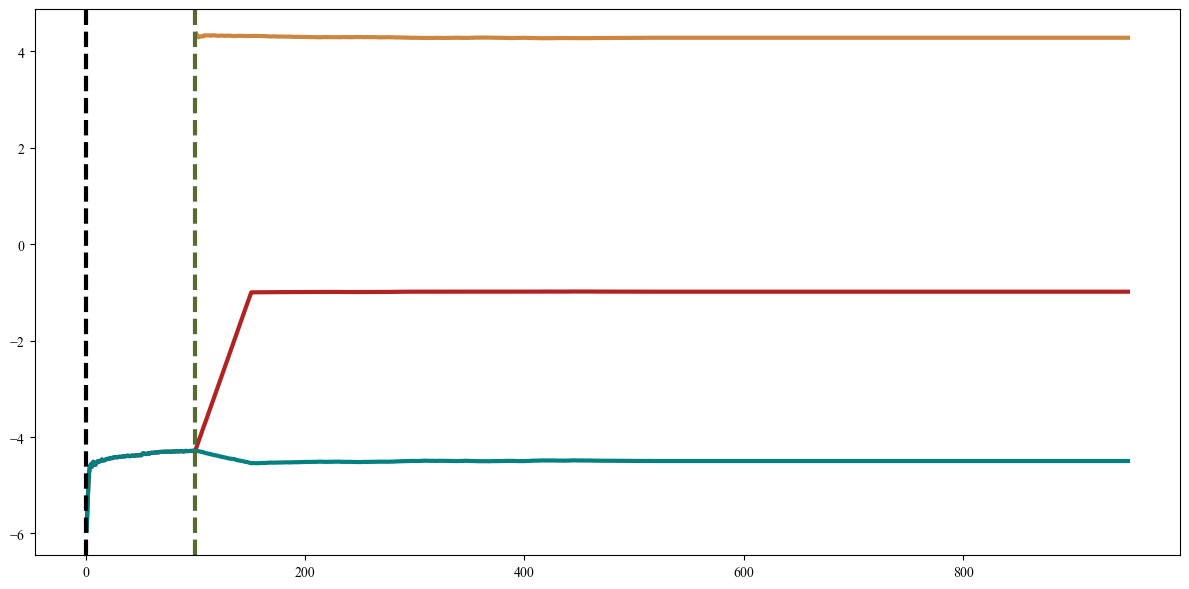

In [25]:
env.plot_results()

> The plots reveal that the introduction of AVs into urban traffic influences human agents' decision-making. This insight highlights the need for research aimed at mitigating potential negative effects of AV introduction, such as increased human travel times, congestion, and subsequent rises in $CO_2$ emissions.

| |  |
|---------|---------|
| **Action shifts of human and AV agents** ![](plots_saved/actions_shifts.png) | **Action shifts of all vehicles in the network** ![](plots_saved/actions.png) |
| ![](plots_saved/rewards.png) | ![](plots_saved/travel_times.png) |


<p align="center">
  <img src="plots_saved/tt_dist.png" width="700" />
</p>


> Interrupt the connection with `SUMO`.

In [ ]:
env.stop_simulation()